# Determining a data processing scheme.

In [518]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import mscl_utils as mscl

import skimage.io
import skimage.measure
import skimage.morphology
import skimage.segmentation
import skimage.filters
import scipy.ndimage

import pandas as pd
import untangle 
import xmltodict

colors = mscl.set_plotting_style()
%matplotlib inline

## Mapping intensity to survival 

The point of this notebook is to try to figure out some scheme for uniting the segmentation masks from the pre shock period and the corresponding fluorescence intensity to that after the shock occurs. I cannot map them directly onto each other as there is some cell movement and growth after the first two images are taken. While I won't be able to use the entire image for a cross correlation analysis, I may be able to use some cross correlation of the surrouding of a given object with two masks. In that case, I may be able to get some translational information for individual masks or do some very basic lineage analysis.

##  Finalizing the segmentation analysis

So far, I've worked on some ways of using contouring to segment cells in phase contrast. I think this will be a better move than just doing thresholding or by doing edge detection as it seems to be a bit more specific to bacterial cells. In the following section, I will build upon the `contour_seg` function I wrote in the `optimizing_contour_segmentation` notebook to complete the saga.

The dat I will be using come from the SD2 strain. I will be looking at cells before the 5μL per minute shock that HJ exposed them to.  

In [519]:
# Define the data sets. 
pre_glob = glob.glob('data/sd2_test_data/pos3_pre/*Brightfield*.tif')
pre_phase = skimage.io.imread(pre_glob[0])
pre_fluo = skimage.io.imread('data/sd2_test_data/pos3_pre/img_000000000_GFP_000.tif')
post_glob = glob.glob('data/sd2_test_data/pos3_post/*Brightfield*.tif')
post_phase = skimage.io.imread(post_glob[0])

# Define the colormaps to be used. 
gray = plt.cm.Greys_r
fluo = plt.cm.viridis
spec = plt.cm.spectral

Now that they're loaded, I'm going to finish writing the segmentation function such that it returns a labeled segmentation mask at the end of the day rather than just an array of contours.  

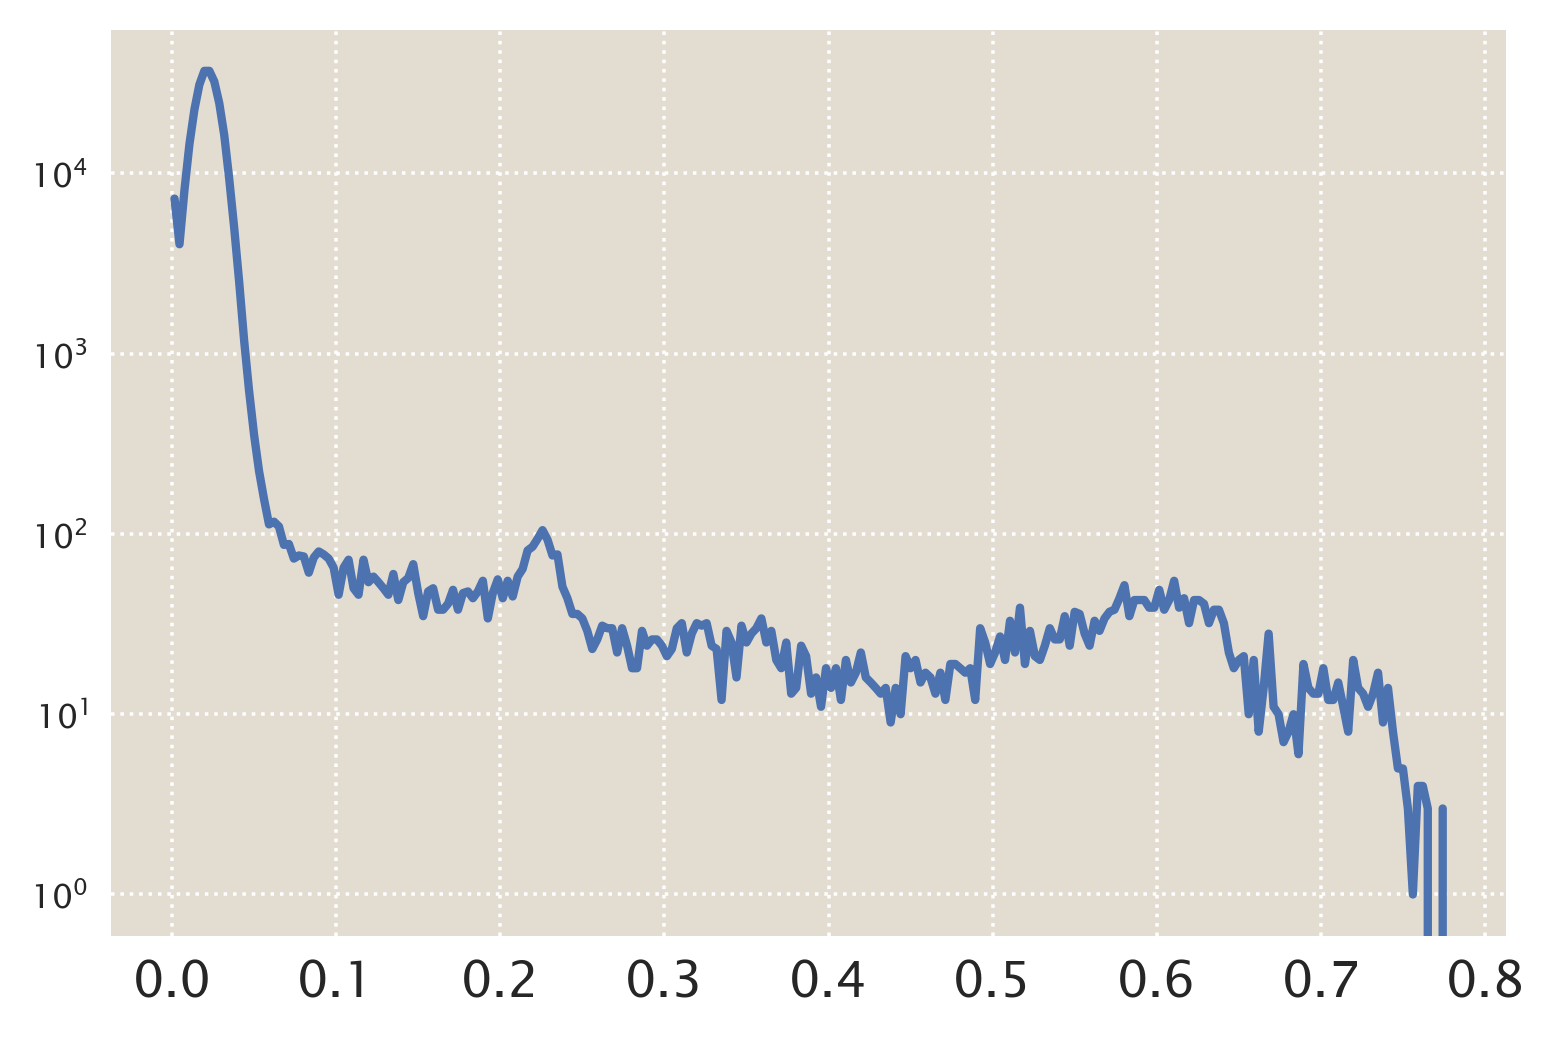

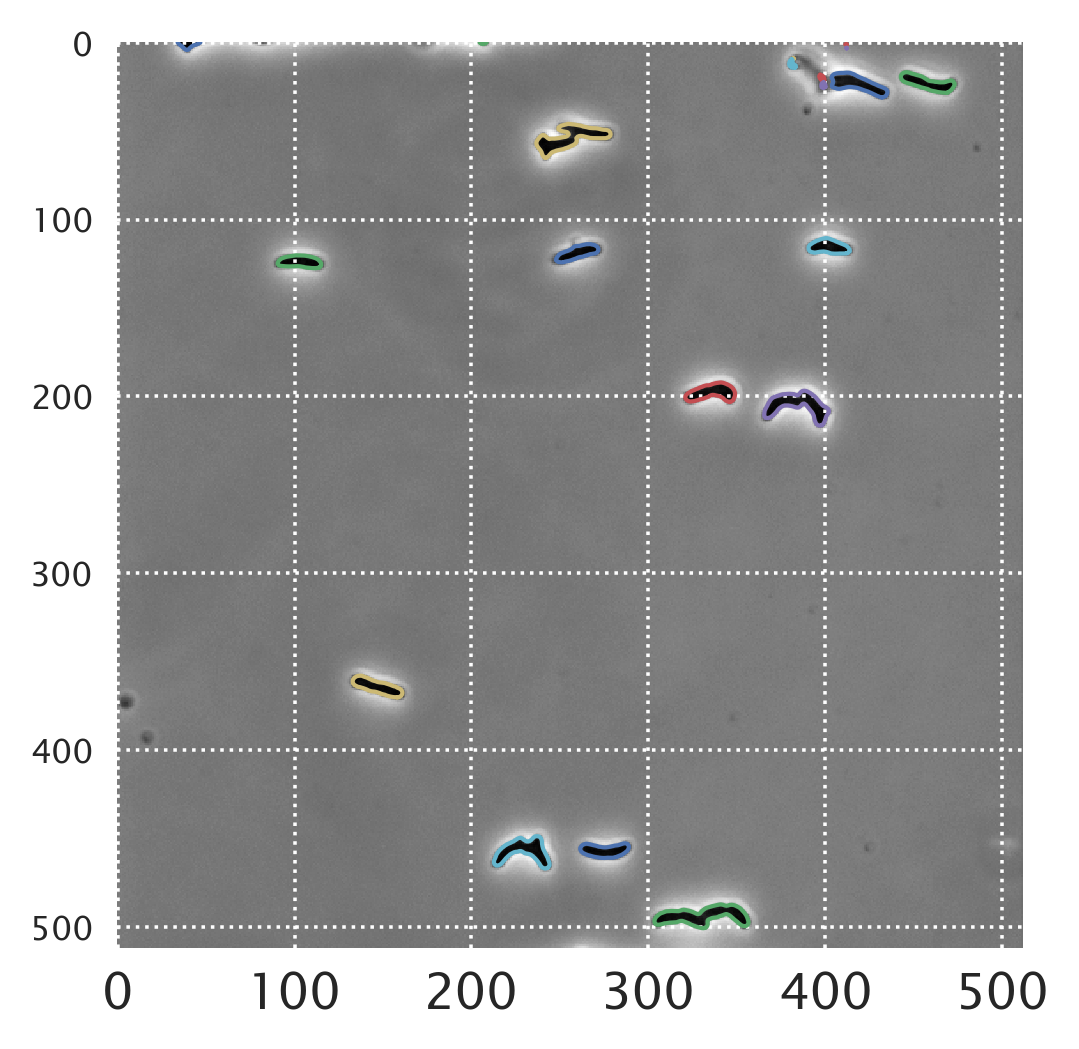

In [520]:
# Define the structural element for contour identification. 
selem = skimage.morphology.disk(20)

# Normalize the image. 
im_norm = (pre_phase - pre_phase.min()) / (pre_phase.max() - pre_phase.min())

# Blur the image. 
im_blur = skimage.filters.gaussian(im_norm, sigma=5)
im_sub = im_norm - im_blur

# Take the black tophat filter of the image.
im_filt = skimage.morphology.black_tophat(im_sub, selem)
import skimage.exposure
hist, bins = skimage.exposure.histogram(im_filt)
plt.figure()
plt.plot(bins, hist)
plt.yscale('log')
# Compute the contours. 
conts = skimage.measure.find_contours(im_filt, 0.4)

# Show the original image.
plt.figure()
plt.imshow(pre_phase, cmap=gray)

# Plot the contours as lines. 
for i, c in enumerate(conts):
    plt.plot(c[:,1], c[:,0], lw=1)

There are a few ways inwhich I can filter out the crappy cells. I can do this by filling the contours, computing the area, and then implying area bounds. I can also do this by imposing a perimeter filter on the leveled contours. This is not so simple as to just measure the length of the contour as there can be many points resting on a detailed contour even if the object is small. However, I can compute the distance between two $x,y$ pairs and tranlate that into a physical distance as I know the interpixel distance of the camera I used. Let's trying generating a vector of the total segmented perimeter. Knowing the geometry of *E. coli* as I do, I would expect to yield a perimeter of around 10-ish microns. Since I have many cells merged together here, I think I'll get a distribution of around 15 ish microns. 

In [521]:
# Define the interpixel distance for the camera. 
ip_dist = 0.160  # in units of microns per pixel. 

# Set up a storage vector for the perimeter. 
perimeter = np.zeros(len(conts))

# Loop through each contour and compute the distance between points. 
for i, c in enumerate(conts):
    perim = 0
    for j in range(len(c) - 1):
        distance = np.sqrt((c[j+1, 0] - c[j, 0])**2 + (c[j+1, 1] - c[j, 1])**2)
        perim += distance * ip_dist
    perimeter[i] = perim

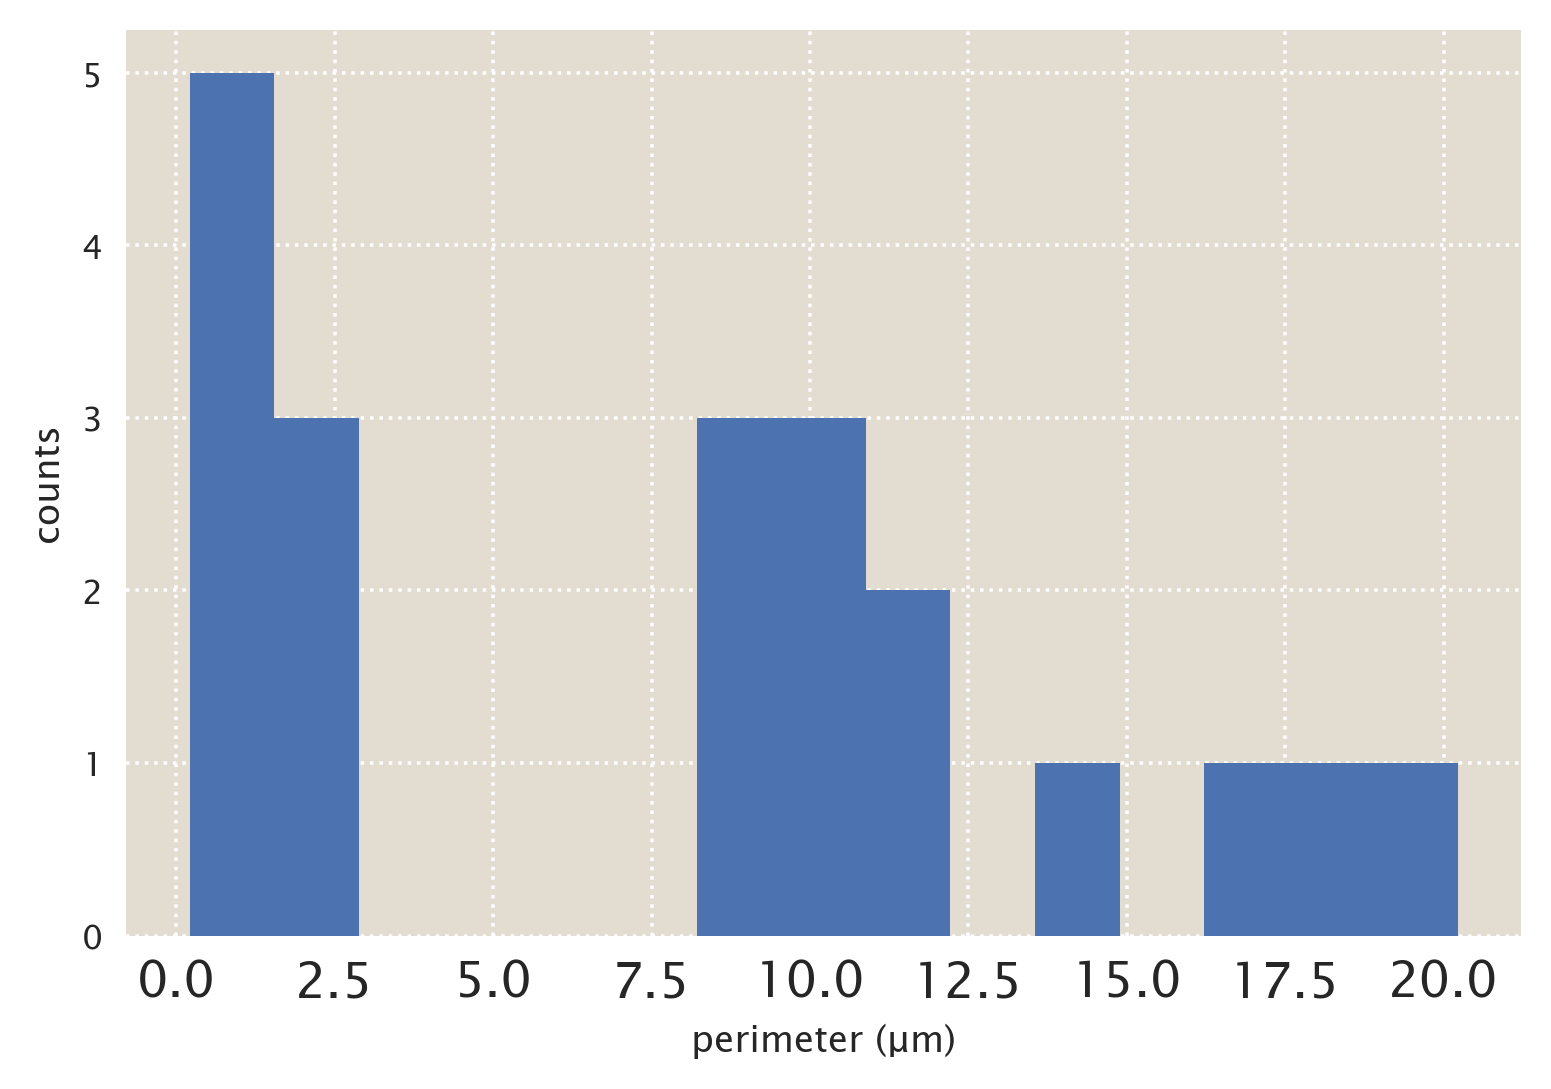

In [522]:
# Plot the histogram. 
plt.hist(perimeter, bins=15)
plt.xlabel('perimeter (μm)')
plt.ylabel('counts')

That seems to have done the trick and  my guess seems to have been pretty okay about what the perimeter should be. I can now just rerun this procedure only keeping the contours which are greater than 5 microns long.

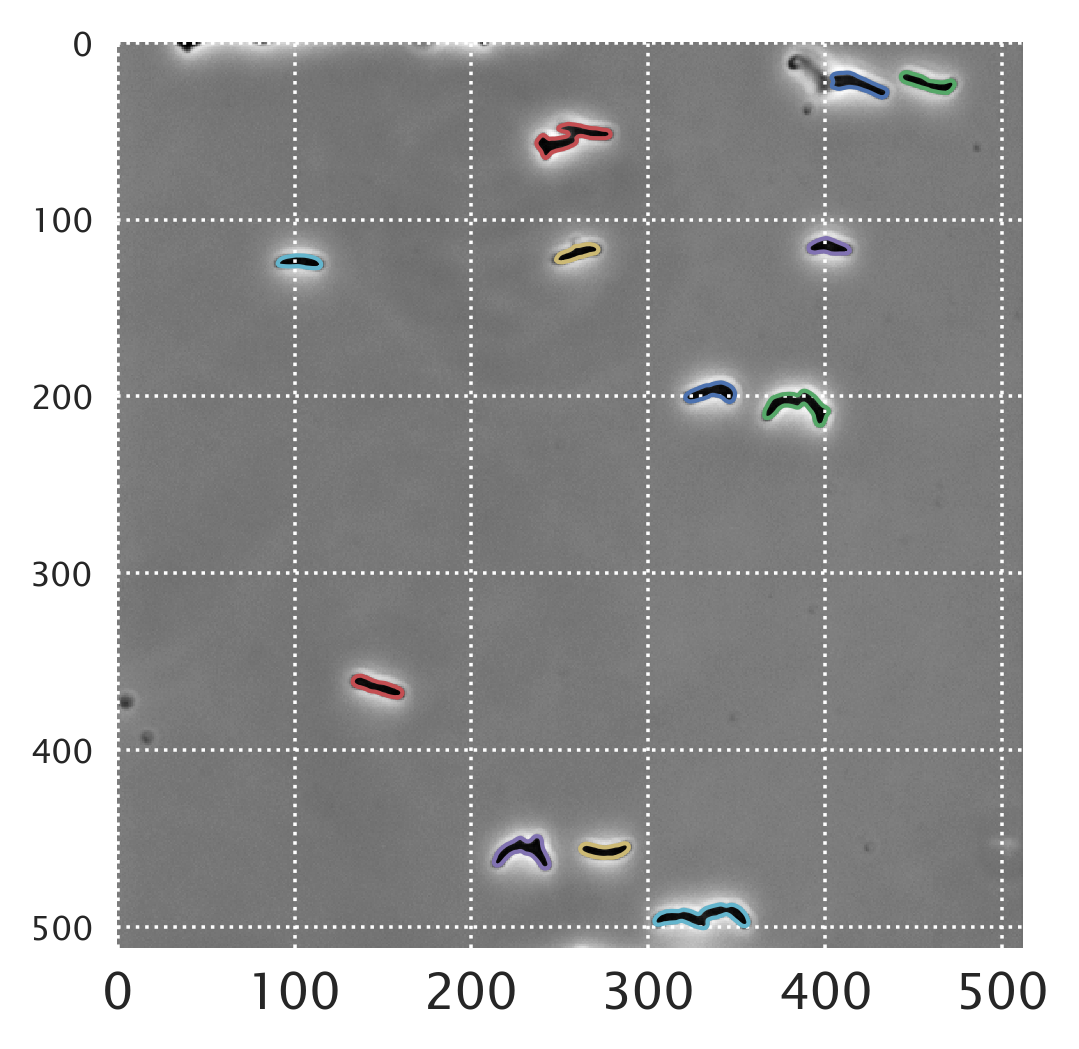

In [523]:
# Set the perimeter bounds in units of microns.
perim_bounds = (5, 25)

# Loop through and keep only those within the bounds.
accepted_conts = []
for i, c in enumerate(conts):
    perim = 0
    for j in range(len(c) - 1):
        distance = np.sqrt((c[j+1, 0] - c[j,0])**2 + (c[j+1, 1] - c[j, 1])**2)
        perim += distance * ip_dist
    if (perim > perim_bounds[0]) & (perim < perim_bounds[1]):
        accepted_conts.append(c)
        
# Show the image again and only the accepted contour. 
plt.imshow(pre_phase, cmap=gray)
for _, c in enumerate(accepted_conts):
    plt.plot(c[:,1], c[:,0], lw=1)

Now that I've filtered out all of the junk and only have the cells, I can try to round the $x, y$ positions of all of the contour points and fill them in a binary image. and label them. This will finalize the "stupid" segmentation procedure.  

Identified 12 cells!


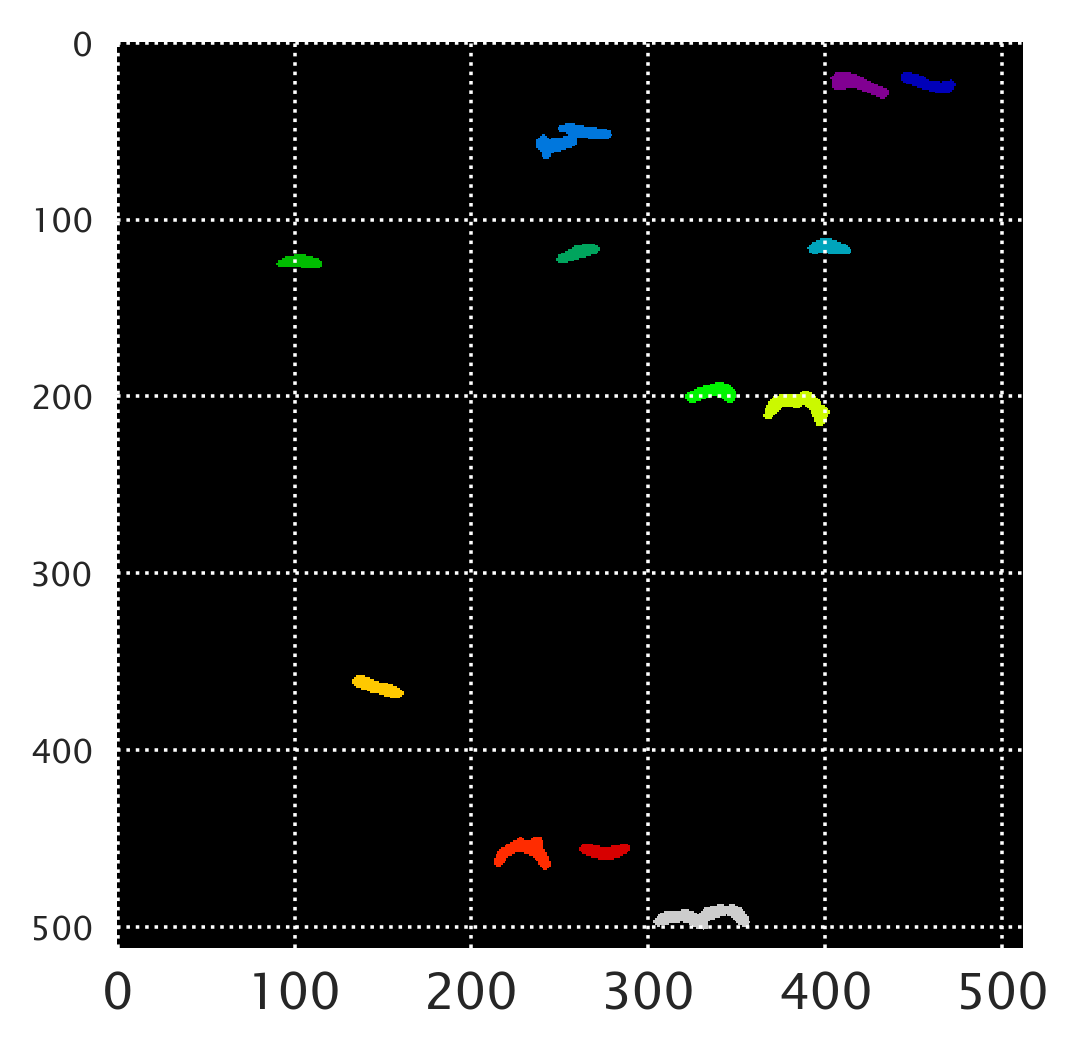

In [524]:
# Make an empty image and fill in all of the contours. 
cells = np.zeros_like(pre_phase)
for i, c in enumerate(accepted_conts):
    c = np.round(c).astype(int)
    
    # Slice the approved cell image. 
    cells[c[:,0], c[:,1]] = 1.0
    
    # Fill the image. 
    cells = scipy.ndimage.binary_fill_holes(cells)

cells = skimage.morphology.remove_small_objects(cells)
cells = skimage.segmentation.clear_border(cells)
# Label the image and show it. 
cells, num_cells = skimage.measure.label(cells, return_num=True)
print('Identified {0} cells!'.format(num_cells))
plt.imshow(cells, cmap=spec)

That seems to do the trick. Let's wrap this into a funciton so I don't have to type everything over and over again. 

In [525]:
def contour_seg(image, level=0.4, selem='default', perim_bounds=(5, 25),
                    ip_dist=0.160, return_conts=False):
    """
    Identifies contours around dark objects in a phase contrast image.

    Parameters
    ----------
    image: 2d-array
        Phase contrast image of interest. This shoul
    level: float
        Level at which to draw contours on black top-hat filtered image.
        Default value is 0.4. 
    selem: 2d-array or string
        Structuring element to use for the black top-hat filtering procedure
        Default value is a disk with a diameter of 20 pixels.
    perim_bounds: length 2 tuple
        Lower and upper perimeter bounds of approved objects. This should be
        in units of microns. The default values are 5 and 25 microns for the
        lower and upper bound, respectively.
    ip_dist : float
        Interpixel distance of the image in units of microns per pixel. The
        default value is 0.160 microns per pixel. 
    return_conts : bool
        If True, the x and y coordinates of the individual contours will be 
        returned. Default value is False

    Returns
    -------
    im_lab : 2d-array, int
        Two dimensional image where each individual object is labeled. 
        
    conts : 1d-array
        List of contour coordinates. Each entry of this array comes as
        an x,y pair of arrays. Has the same length as the number of
        contoured objects. This is only returned if `return_conts` is 
        True.

    """

    # Apply the white top-hat filter.
    if selem == 'default':
        selem = skimage.morphology.disk(20)
        
    # Normalize the image. 
    image = (image - image.min()) / (image.max() - image.min())
    
    # Blur and background subtract the image. 
    im_blur = skimage.filters.gaussian(image, sigma=5)
    im_sub = image - im_blur
    
    # Apply the black tophat filter. 
    im_filt = skimage.morphology.black_tophat(im_sub, selem)

    # Find the contours and return.
    conts = skimage.measure.find_contours(im_filt, level)
    
    # Make an empty image for adding the approved objects. 
    objs = np.zeros_like(image)
    
    # Loop through each contour. 
    for _, c in enumerate(conts):
        perim = 0
        for j in range(len(c) - 1):
        
            # Compute the distance between points.
            distance = np.sqrt((c[j+1, 0] - c[j, 0])**2 +\
                               (c[j+1, 1] - c[j, 1])**2)
            perim += distance * ip_dist
            
        # Test if the perimeter is allowed by the user defined bounds. 
        if (perim > perim_bounds[0]) & (perim < perim_bounds[1]):

            # Round the contours. 
            c_int = np.round(c).astype(int)
            
            # Color the image with the contours and fill. 
            objs[c_int[:,0], c_int[:, 1]] = 1.0
            
    # Fill and label the objects.
    objs_fill = scipy.ndimage.binary_fill_holes(objs)
    objs_fill = skimage.morphology.remove_small_objects(objs_fill)
    objs_border = skimage.segmentation.clear_border(objs_fill)
    im_lab = skimage.measure.label(objs_border)
    if return_conts == True:
        return conts, im_lab
    else:
        return im_lab

Now we can run this function on our original image and make sure that we have the same result. 

In [526]:
# Make sure the function works as advertised. 
func_lab = contour_seg(pre_phase)
test = (cells == func_lab).all()
print("Are the two masks the same? Computer says '{0}'".format(test))

Are the two masks the same? Computer says 'True'


Okay, so it looks like my function returns the proper thing. For fun, lets take a look at the distribution of fluorescence from the pre image.  

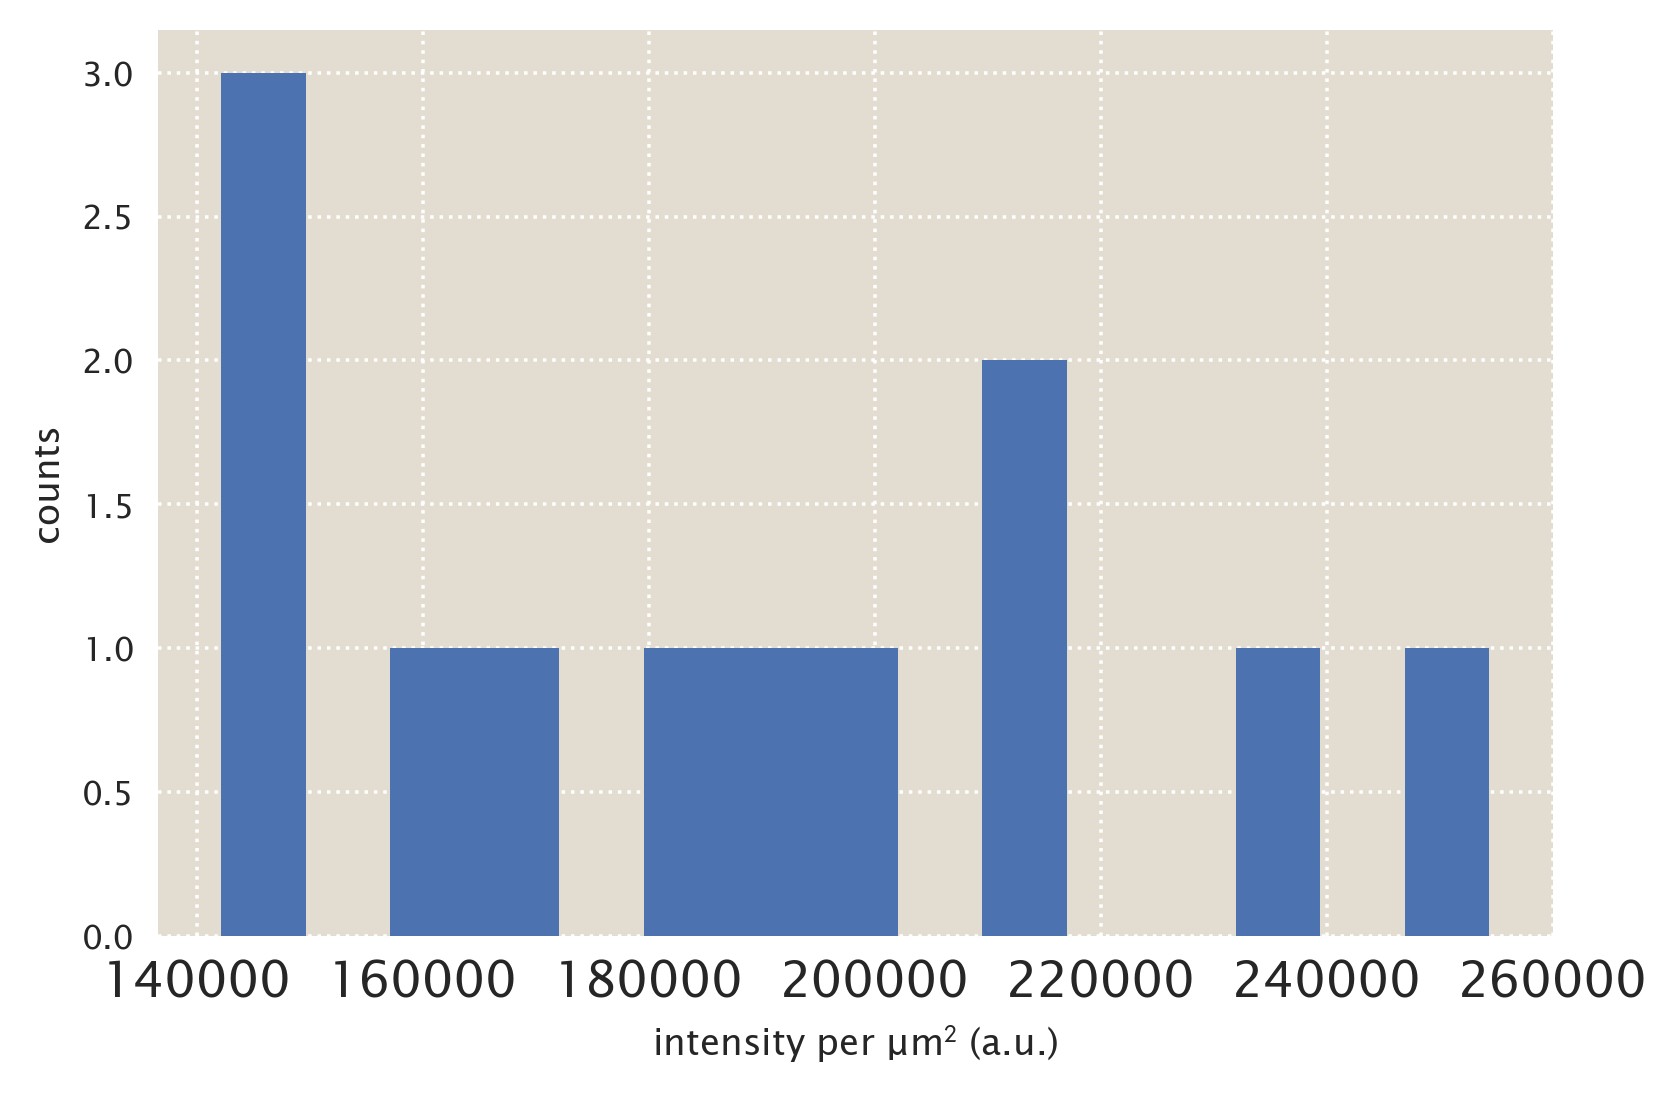

In [527]:
# Get the region properties for the fluorescence image. 
props = skimage.measure.regionprops(func_lab, pre_fluo)
fluo_density = []
for prop in props:
    area = prop.area * ip_dist**2
    total_int = prop.mean_intensity * prop.area
    fluo_density.append(total_int / area)  # in units of A.U per sq micron
    
# Now take a look at the distribution. 
plt.hist(fluo_density, bins=15)
plt.xlabel('intensity per μm$^2$ (a.u.)')
plt.ylabel('counts')

Now for the hard part.

##  Marrying the pre- and post-shock images

So I have an idea of what I'm looking to do, let's look at the two images side by side after segmenting. I'll make a nice merge so it's easier to see how things are
moving.

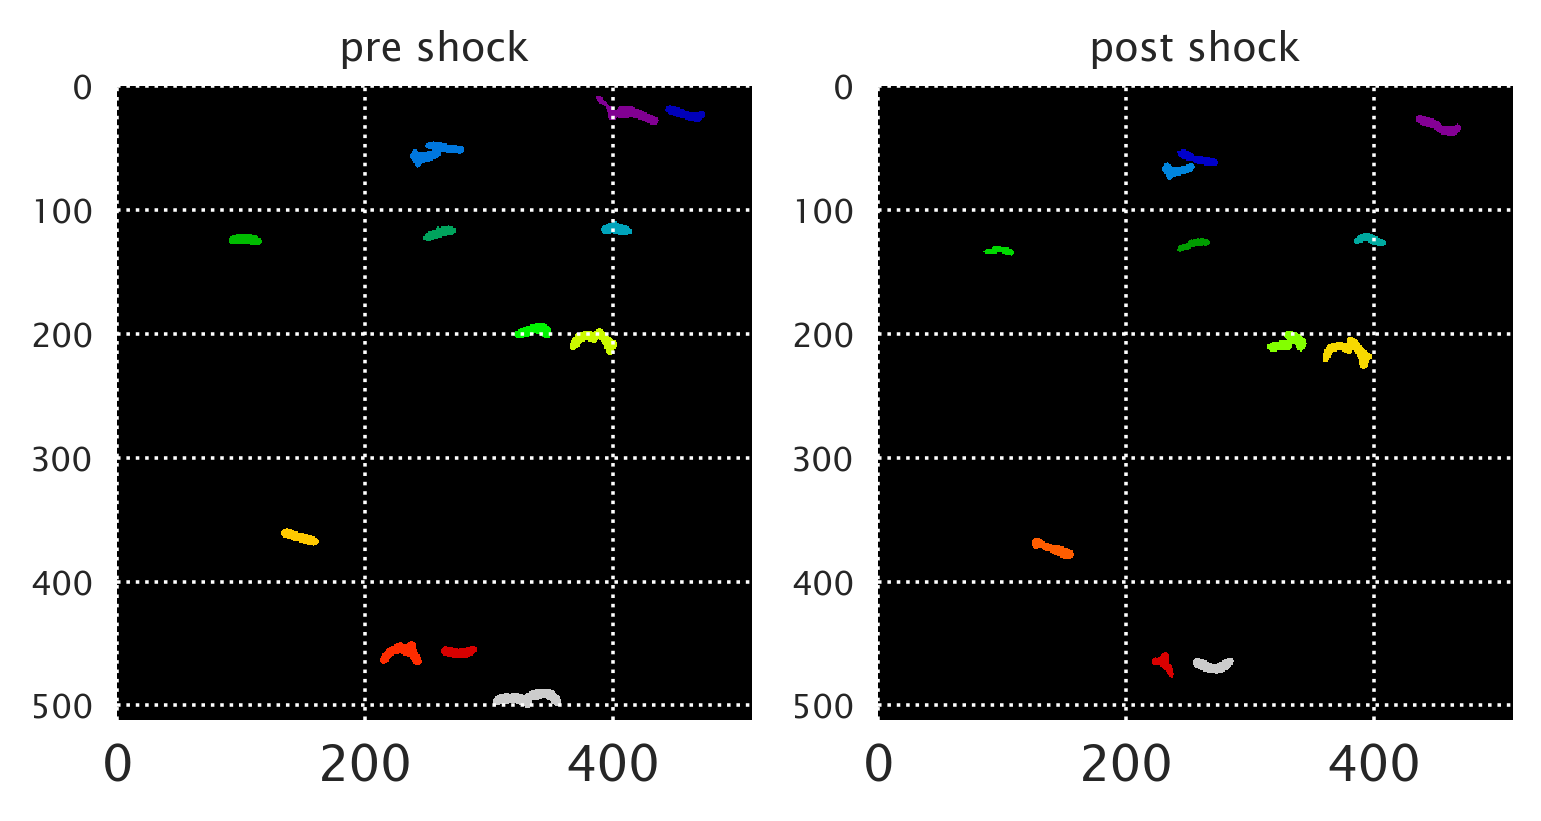

In [528]:
# Segment the two images. 
pre_seg = contour_seg(pre_phase, 0.3)
post_seg = contour_seg(post_phase, 0.3)

# Define the figure and show both images. 
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pre_seg, cmap=spec)
ax[1].imshow(post_seg, cmap=spec)
ax[0].set_title('pre shock')
ax[1].set_title('post shock')

We can see that there is a little bit of movement **and** death between these two frames. This is going to be a bit difficult to deal with. Let's take a look at a single window of one of the objects. I'll choose two $-$ one that doesn't move much and one that does. I'll do this on the original segmentation image and look at the same region on the post-shock phase image.

In [529]:
# Find the total number of objects. 
num_obj = np.max(pre_seg)
print('The total number of segmented objects is {0}'.format(num_obj))

The total number of segmented objects is 12


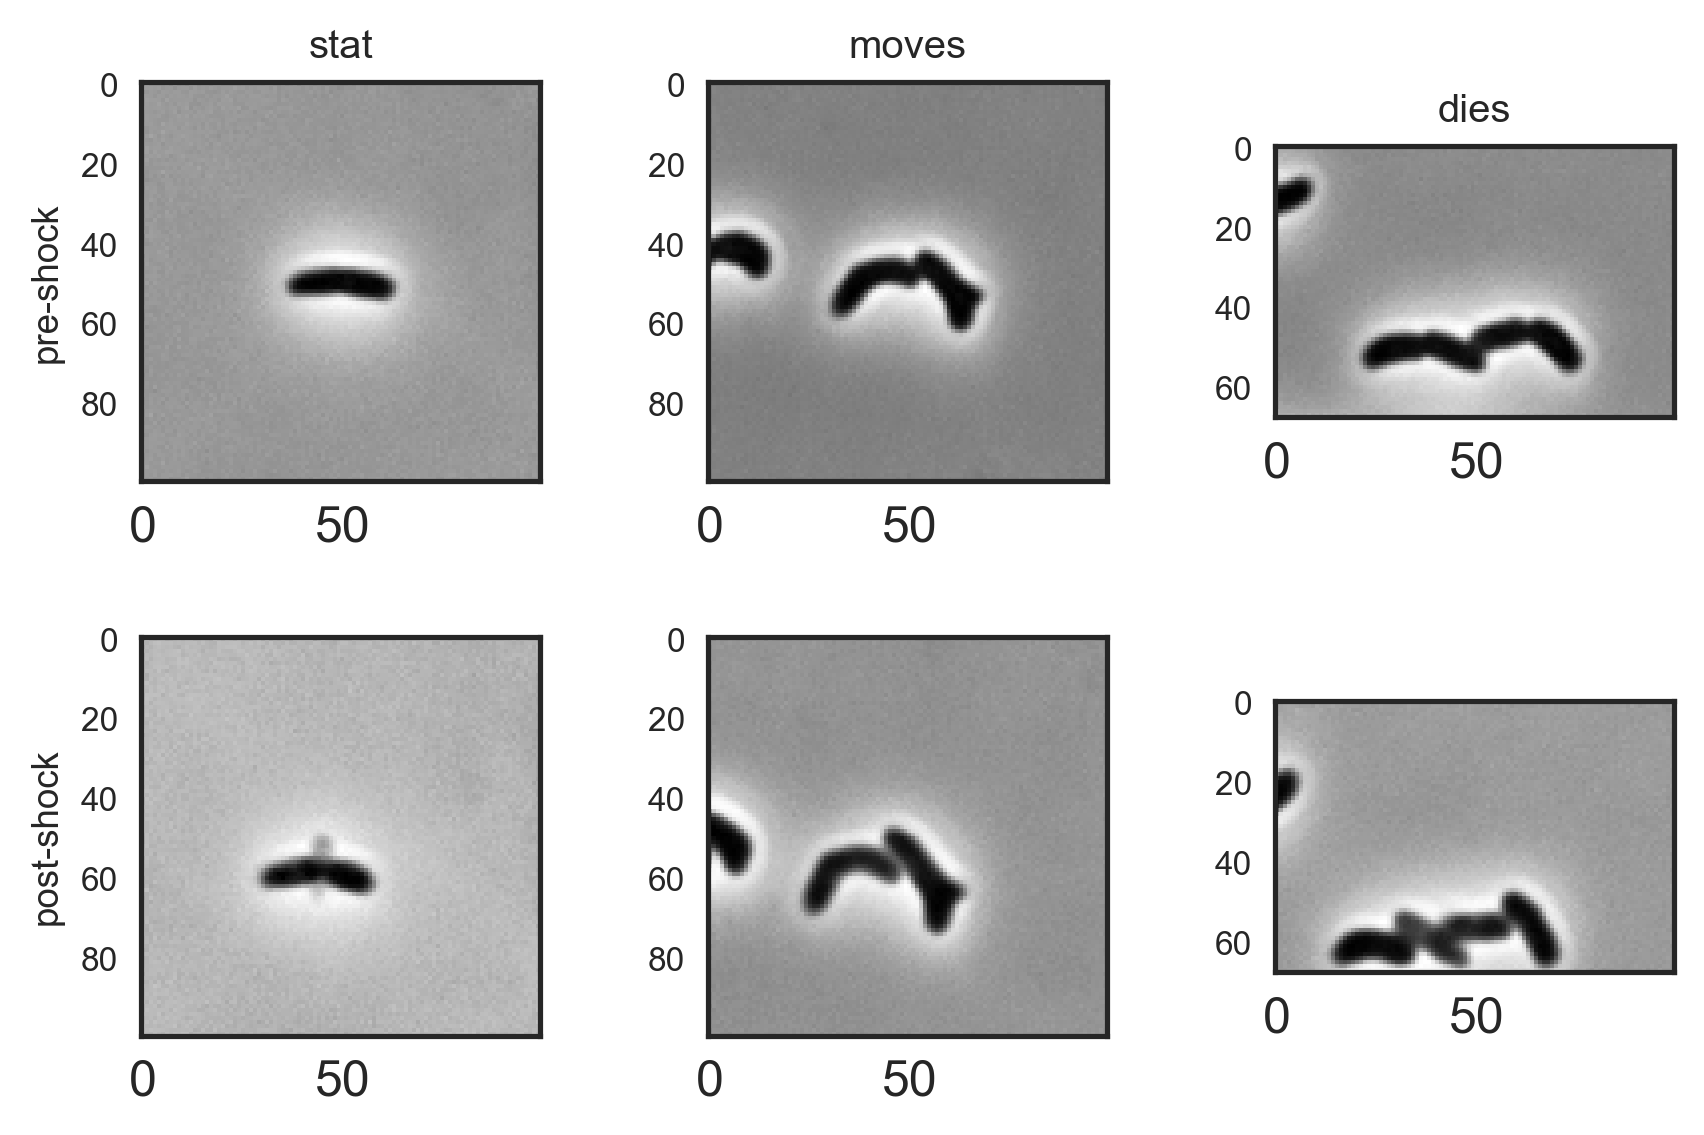

In [530]:
# Pick some usefult test cases.
stationary = 5 
moves = 7 
dies = 11 

# Make these choices a list for easy iterating. 
choices = [stationary, moves, dies]

# Get the centroid of each and expand the bounding box. 
bbox = []
props = skimage.measure.regionprops(pre_seg)
for i, chc in enumerate(choices):
    cent = np.round(props[chc].centroid).astype(int)
    slc = np.s_[cent[0]-50: cent[0] + 50, cent[1] - 50: cent[1] + 50]
    bbox.append(slc)
    
# Make life easier by making the bbox a nice dictionary.
bbox = {'stat' : bbox[0], 'moves' : bbox[1], 'dies' : bbox[2]}     

# Slice all three and show both images. 
keys = ['stat', 'moves', 'dies']

with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 3)
    for i, key in enumerate(keys):
        ax[0, i].imshow(pre_phase[bbox[key]], cmap=gray)
        ax[1, i].imshow(post_phase[bbox[key]], cmap=gray)
        ax[0, i].set_title(key)
        
    ax[0, 0].set_ylabel('pre-shock')
    ax[1, 0].set_ylabel('post-shock')
    plt.tight_layout()

Now let's try doing the same thing except now showing the segmentation masks.

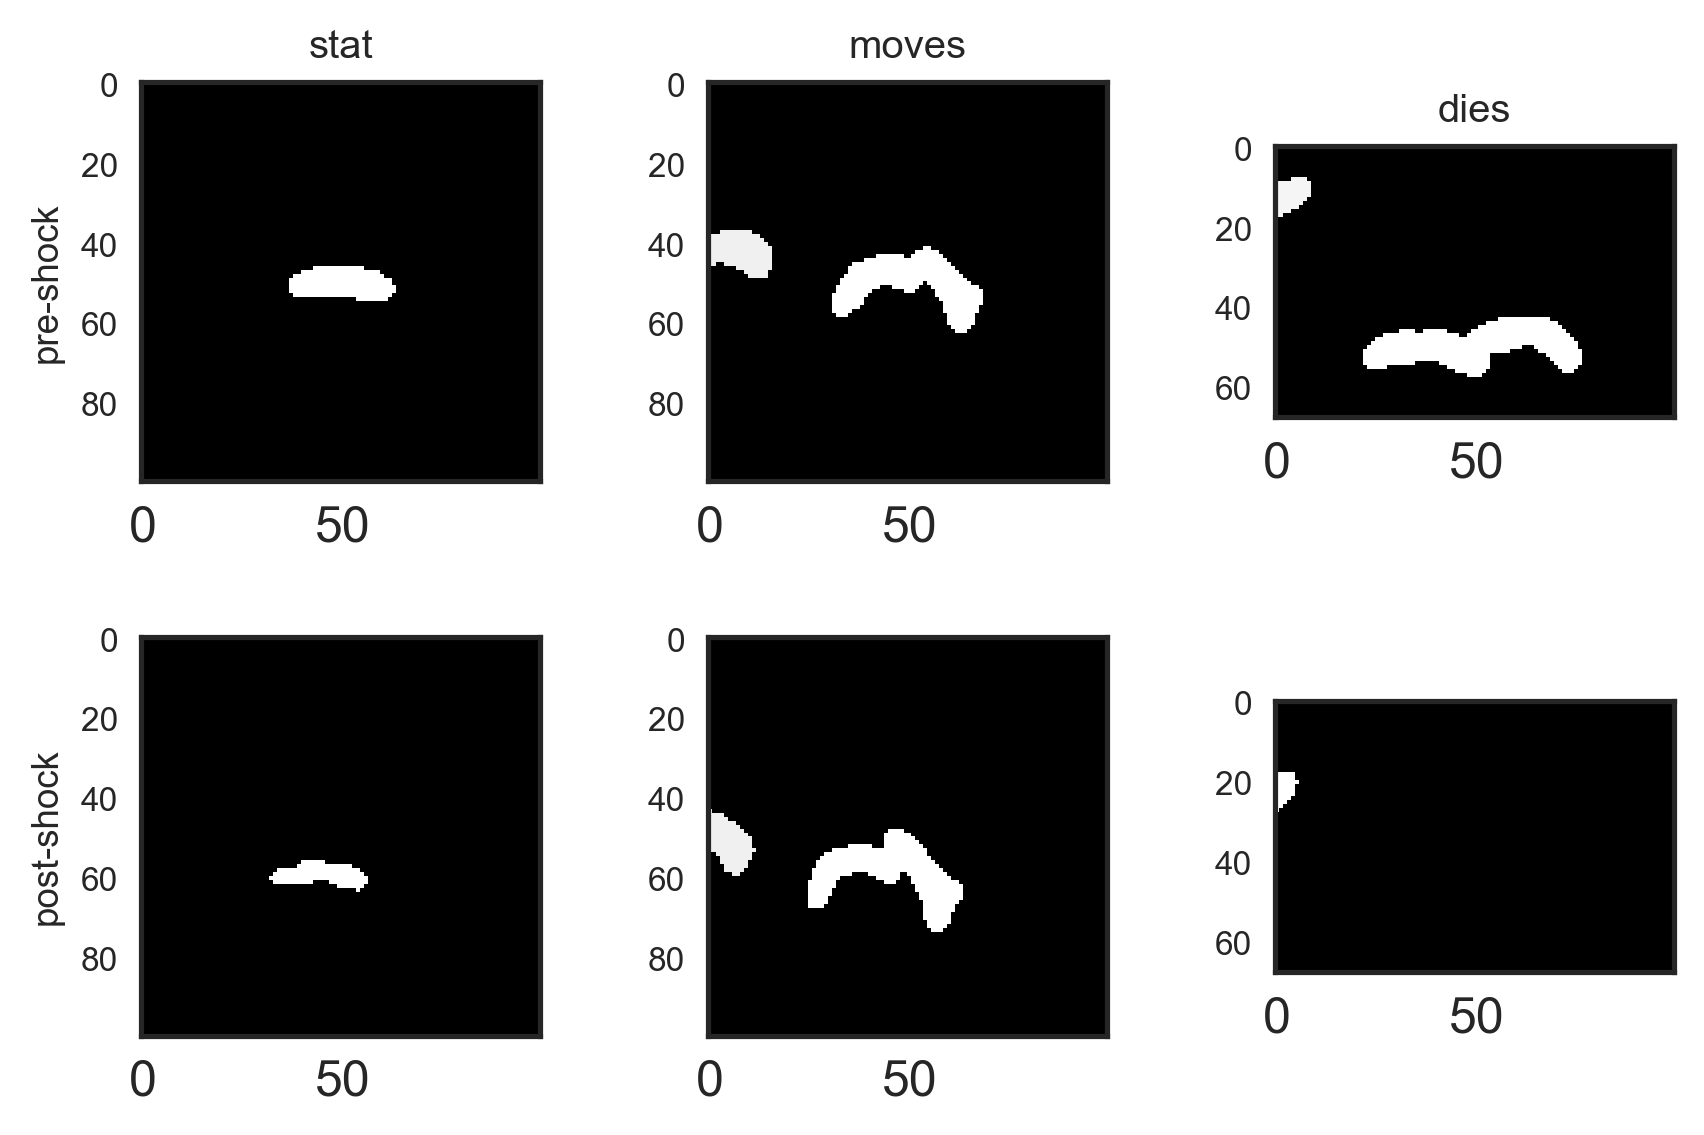

In [531]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(2, 3)
    for i, key in enumerate(keys):
        ax[0, i].imshow(pre_seg[bbox[key]], cmap=gray)
        ax[1, i].imshow(post_seg[bbox[key]], cmap=gray)
        ax[0, i].set_title(key)
        
    ax[0, 0].set_ylabel('pre-shock')
    ax[1, 0].set_ylabel('post-shock')
    plt.tight_layout()

I'm now thinking that actually connecting the segmentation masks is probably not that important. Heun Jin has ardulously gone through the clicking to manually mark which cells are surviving and which have passed onto the other side. The result fo that is an XML document generated through the ImageJ CellProfilier plugin. This XML file basically contains an array of $x$ and $y$ coordinates which are given an identity (`1`, `2`, or `3`), which marks it as a cell that dies, survives long enough to divide twice, or is D.O.A (although I should check all of this with HJ once again). Since these are all just points and I'm interested more in mapping intensity density to survival, this may be all that I really need. I can mark the centroids of all of my segmented cells and compute the shortest distance between them. Whatever the shortest distance is should be the corresponding cell. 

Unfortunately, this means that I have to come up with some clever way of reading in the XML file to parse the positions (thanks CellProfiler). There are numerous Python XML parsing utilities, but one very useful one I found is [`xmltodict`]() which seems to automagically parse an XML file into an object with native attributes. 

Let's try using it to parse the `pos3_cell_markers.xml`.

In [532]:
# Try untangling the CellProfiler XML output. 
with open('data/sd2_test_data/pos3_cell_markers.xml', 'r') as f:
    positions = xmltodict.parse(f.read())

# Extract only the marker data.  
markers = positions['CellCounter_Marker_File']['Marker_Data']['Marker_Type']

# Find the total number of types and loop through them to make data frames.
dfs = []
num_types = len(markers)
types = {1 : False, 2 : True}
for i in range(num_types):
    try:
        _df = pd.DataFrame(markers[i]['Marker'])
        
        # Insert a column keeping track of the type
        _df.insert(0, 'survival', types[int(markers[i]['Type'])])
        dfs.append(_df)
        
    except:
        print('No markers found for type {0}'.format(i + 1))
        pass
    
# Merge all of the dataframes together. 
df = pd.concat(dfs, axis=0, ignore_index=True)
df.drop('MarkerZ', 1, inplace=True)
df.columns = ['survival', 'x_pos', 'y_pos']
df['x_pos'] = df['x_pos'].astype(int)
df['y_pos'] = df['y_pos'].astype(int)

No markers found for type 3
No markers found for type 4
No markers found for type 5
No markers found for type 6
No markers found for type 7
No markers found for type 8


Now that I have this together as a pandas data frame, it should be relatively easy to grab the coordinates of each cell. Let's plot these two survival types on both phase images.

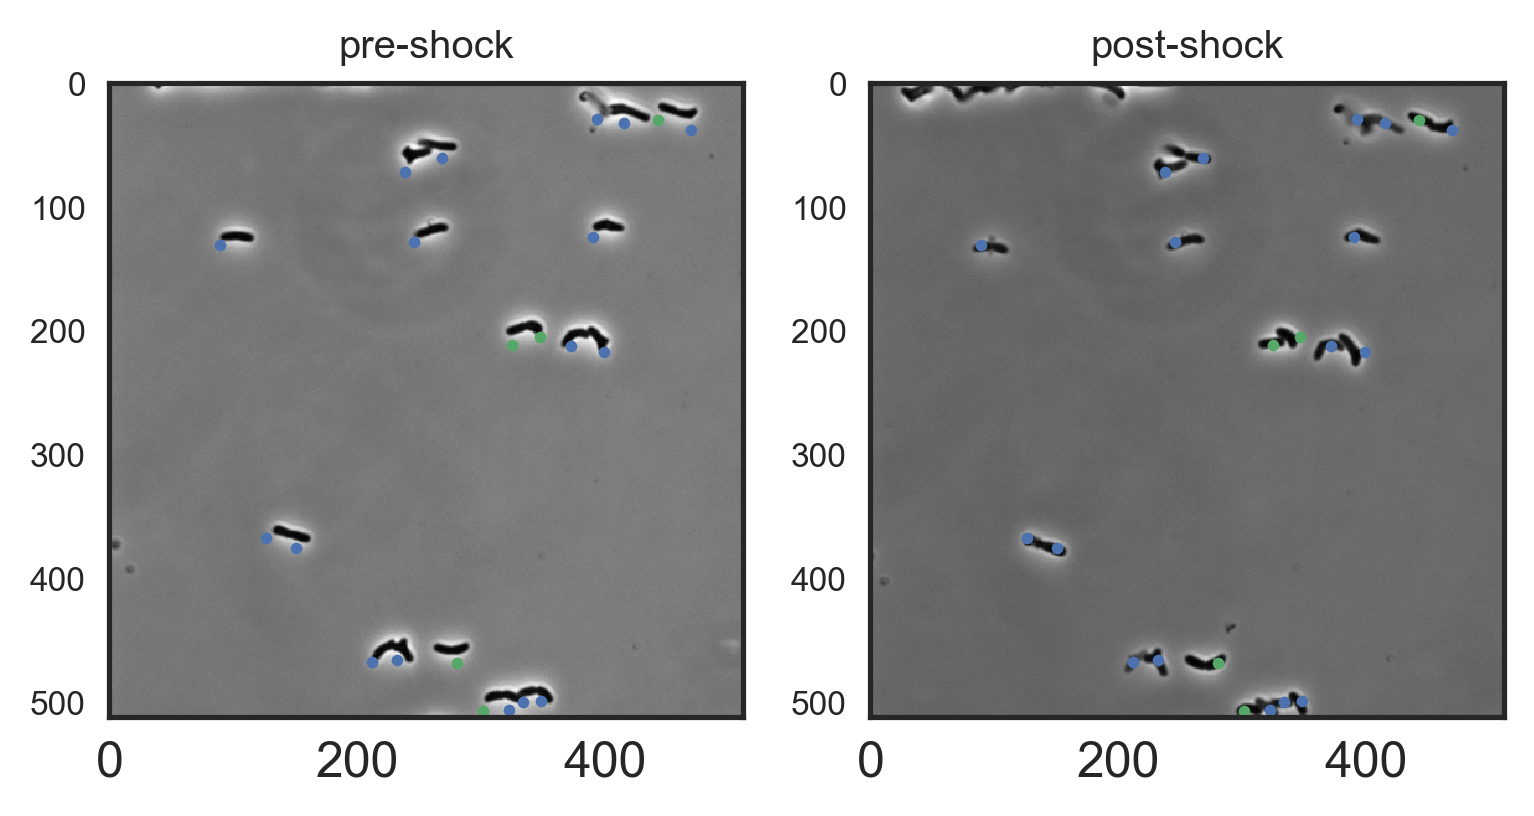

In [533]:
# Group the data by survival. 
grouped = pd.groupby(df, 'survival')

# Show both phase images.
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(pre_phase, cmap=gray)
    ax[1].imshow(post_phase, cmap=gray)
    
    # Loop through and plot the points. 
    for g, d in grouped:
        for a in ax:
            a.plot(d.x_pos, d.y_pos, '.')

        
    # Add some titles for clarity. 
    ax[0].set_title('pre-shock')
    ax[1].set_title('post-shock')

Oh boy that's a lot of death. However, it seems like I'm going to be okay trying to use my stupid minimum distance test. Let's try plotting all of the centroids of the mask in the pre-shock image, the marker coordinates, and the pre-shock phase image together.  

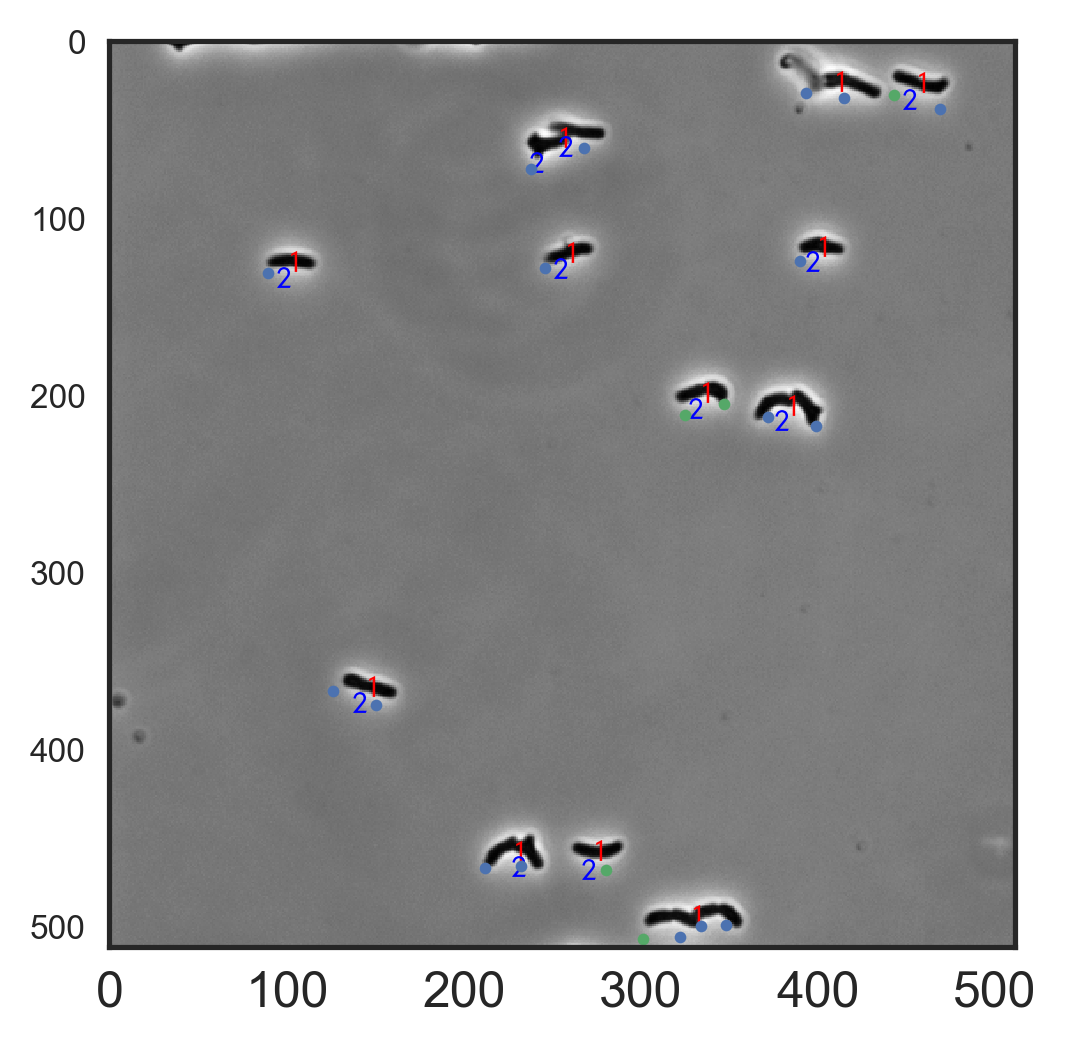

In [534]:
# Get all of the object centroids for the preshock. 
props = skimage.measure.regionprops(pre_seg)
pre_centroids = [prop.centroid for prop in props]
props = skimage.measure.regionprops(post_seg)
post_centroids = [prop.centroid for prop in props]

# Show the image and plot all of the points.
with sns.axes_style('white'):
    plt.imshow(pre_phase, cmap=gray)
    
    # Plot the centroids
    for c in pre_centroids:
        plt.plot(c[1], c[0], marker='$1$', color='r', ms=5)
    for c in post_centroids:
        plt.plot(c[1], c[0], marker='$2$', color='b', ms=5)
        
    for g, d in grouped:
        plt.plot(d.x_pos, d.y_pos, '.')

Now that I have a sense of the positioning, let's go through and compute the minimum distances between the markers and the centroids. I'll end up storing into another data frame the $x, y$ position of the marker, the intensity of the GFP image, the segmentation mask label, and the survival state. 

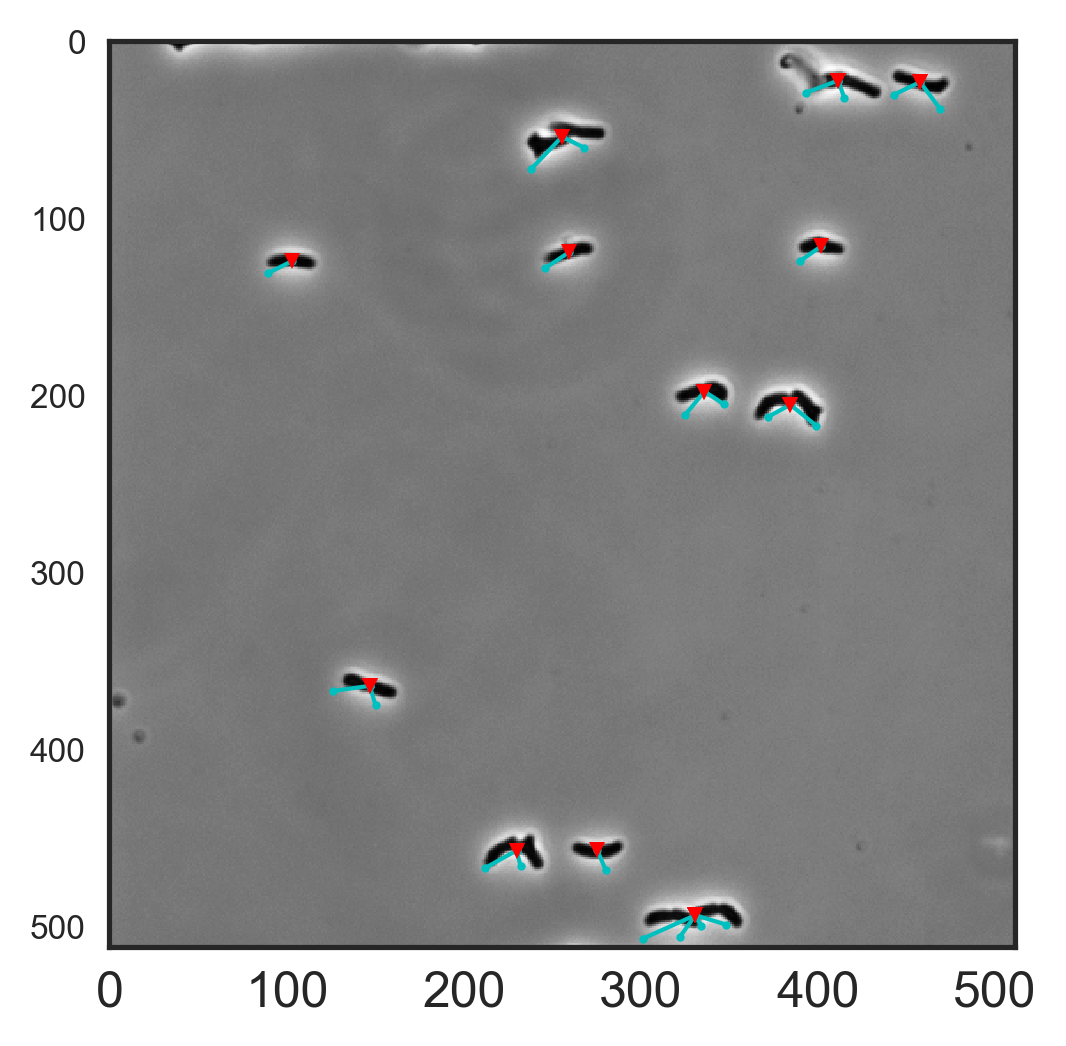

In [535]:
# Get the intensities. 
props = skimage.measure.regionprops(pre_seg, pre_fluo)
intensities = [prop.mean_intensity / ip_dist**2 for prop in props]
labels = [prop.label for prop in props]
areas = [prop.area * ip_dist**2 for prop in props]

with sns.axes_style('white'):
    plt.imshow(pre_phase, cmap=gray)
    # Compute the minimum distances. 
    for i in range(len(df)):
        distances = []
        x, y = df.iloc[i].x_pos, df.iloc[i].y_pos
        
        # Loop through each centroid and find the minimum distance. 
        for c in pre_centroids:
            distances.append(np.sqrt((x - c[1])**2+ (y - c[0])**2))
        
        # Find the index with the minimum distance. 
        min_ind = np.argmin(distances)
            
        # Update the data frame. 
        df.set_value(i, 'mask_label', labels[min_ind])
        df.set_value(i, 'intensity', intensities[min_ind])
        df.set_value(i, 'area', areas[min_ind])
        
        # Plot a line between the centroid and the marker label.  
        plt.plot([x, pre_centroids[min_ind][1]], [y, pre_centroids[min_ind][0]],
                'c-o', lw=1, ms=2)
        plt.plot(pre_centroids[min_ind][1], pre_centroids[min_ind][0], 'rv', ms=4)
        
 

That seemed to do the trick! Now let's take a look at the dataframe.

In [536]:
# Show the DataFrame to make sure life is OK.
df

,survival,x_pos,y_pos,mask_label,intensity,area
0,False,89,131,6.0,144055.288462,4.9920
1,False,246,128,5.0,188229.440789,4.8640
2,False,390,124,4.0,164767.427885,4.9920
3,False,415,32,1.0,135688.947494,10.0864
4,False,238,72,3.0,159211.105310,10.7264
5,False,268,60,3.0,159211.105310,10.7264
6,False,469,38,2.0,145340.570887,5.9136
7,False,393,29,1.0,135688.947494,10.0864
8,False,372,212,8.0,191832.948023,10.0352
9,False,399,217,8.0,191832.948023,10.0352


Lets make a jitter plot of intensity versus survival.  

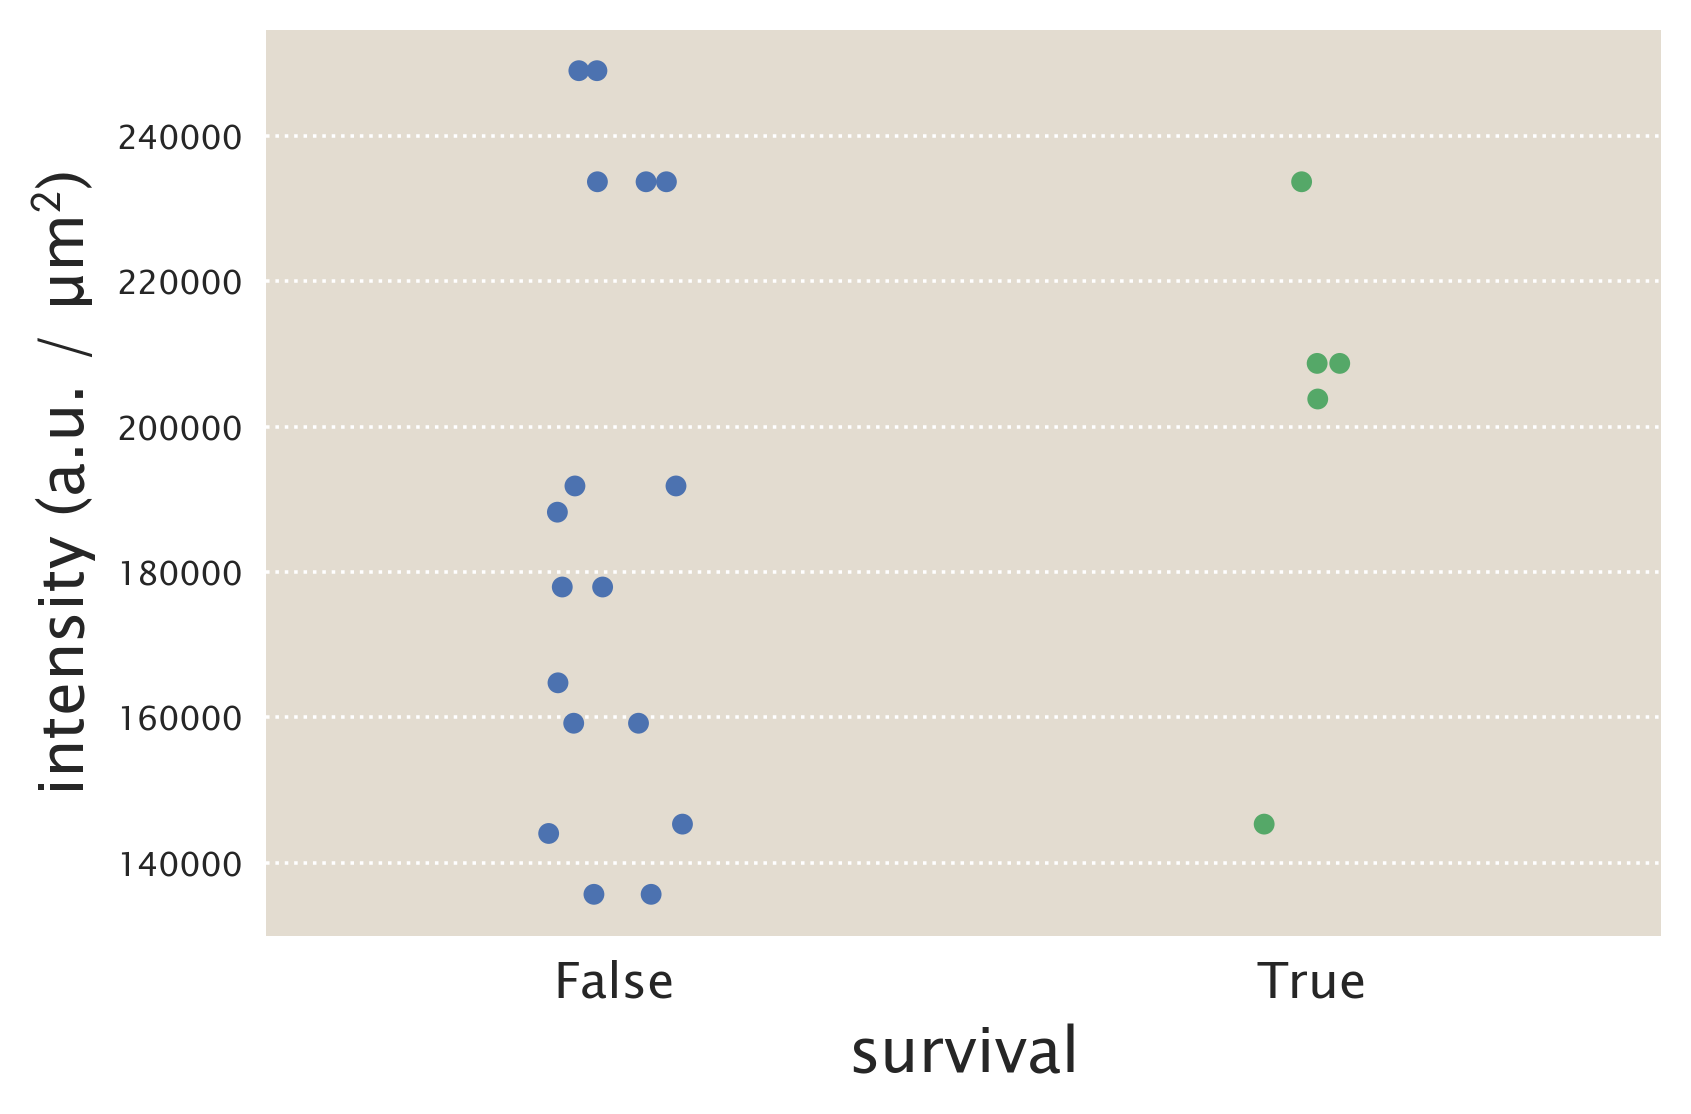

In [537]:
# Plot it as a striplot
sns.stripplot(x='survival', y='intensity', data=df, jitter=True)
plt.xlabel('survival', fontsize=15)
plt.ylabel('intensity (a.u. / μm$^2$)', fontsize=15)

How does the survival correspond to the area?

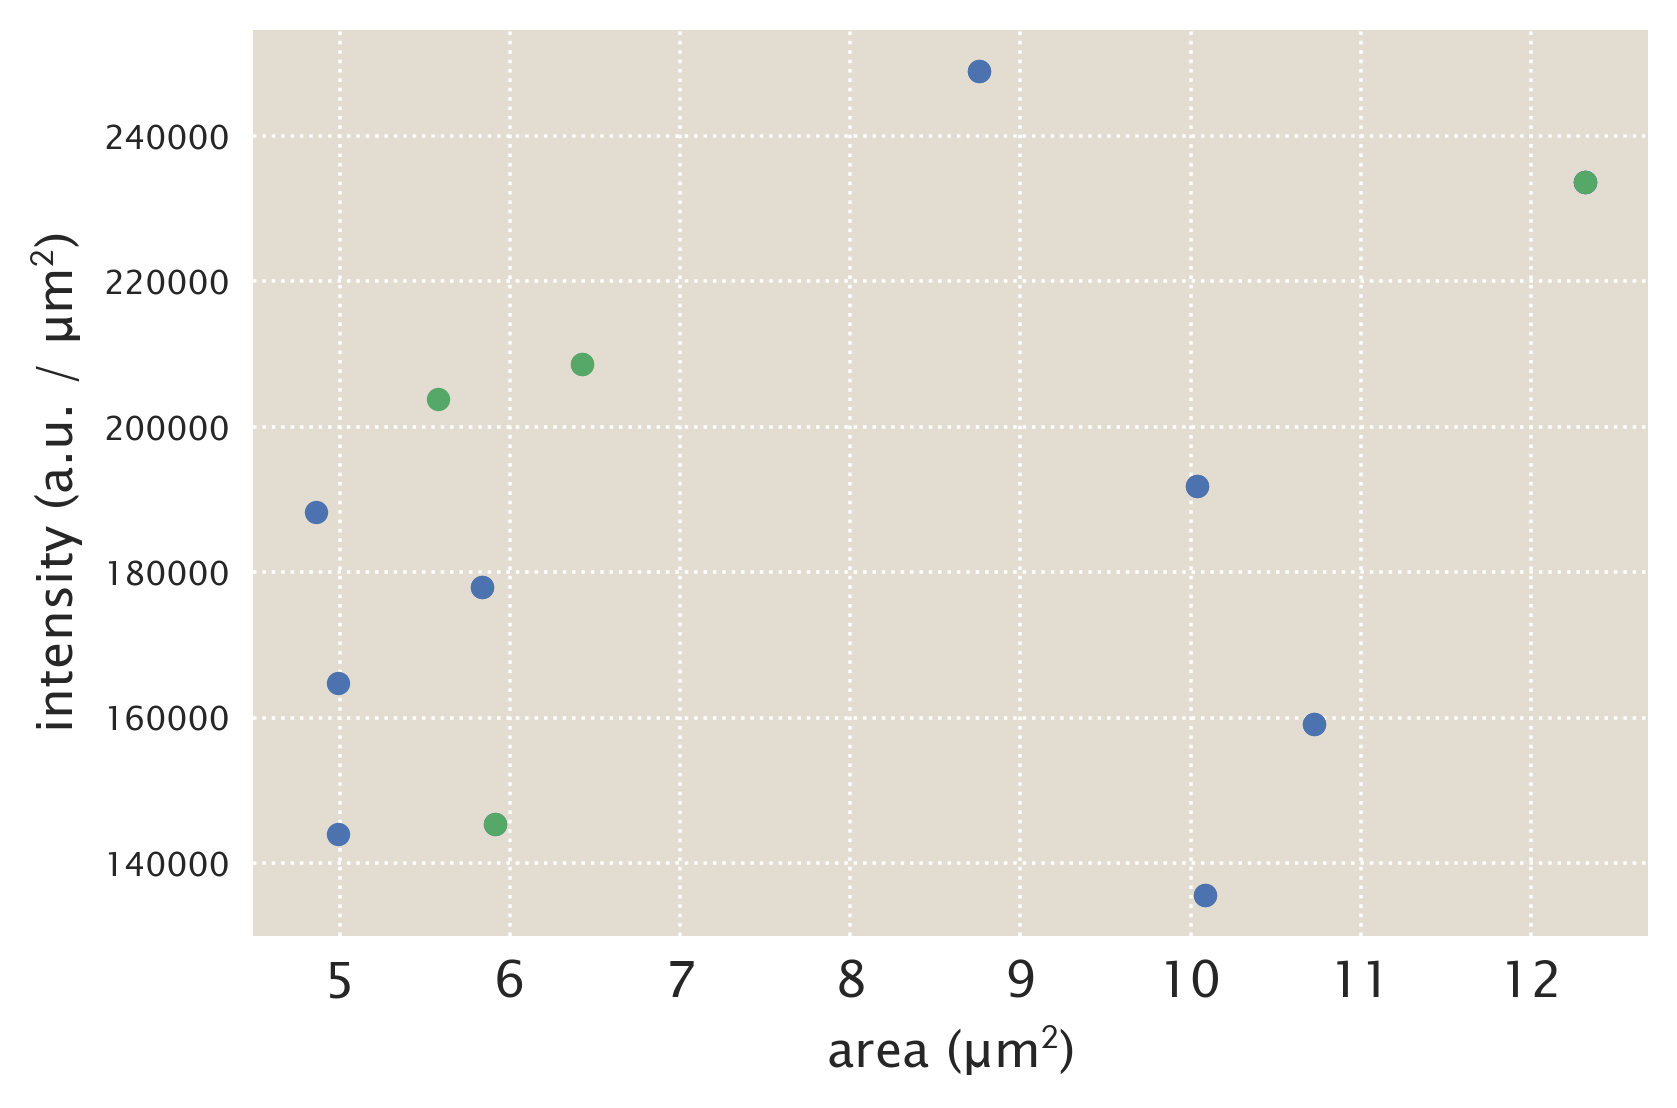

In [538]:
# Plot intensity vs area and color the points by survival.
grouped = pd.groupby(df, 'survival')
labels = {True: 'survivors', False: 'casualties'}
for g, d in grouped:
    plt.plot(d.area, d.intensity, 'o', label=labels[g])
plt.xlabel('area (μm$^2$)', fontsize=12) 
plt.ylabel('intensity (a.u. / μm$^2$)', fontsize=12)

Obviously, I don't have enough data to say anything meaningful. However, it seems like I've converged on a system that seems to work. Below, I've written functions which cover the XML handling and computing of the minimum distances.  

In [565]:
def marker_parse(fname, type_dict={1: False, 2:True}):
    """
    Parses the XML file produced from the CellCounter ImageJ plugin and
    packages the marker positions and type into a Pandas DataFrame. 
    
    Parameters
    ----------
    fname : str
        Path to the XML file of interest. 
    type_dict : dict
        Dictionary of types and survival. Default is assigning type 1 
        as death and type 2 as survival.
    
    Returns
    -------
    df : Pandas DataFrame
        Data frame containing x and y positions of markers as well as
        the type classification. 
    """
    with open(fname, 'r') as f:
        positions = xmltodict.parse(f.read())

    # Extract only the marker data.  
    markers = positions['CellCounter_Marker_File']['Marker_Data']['Marker_Type']

    # Find the total number of types and loop through them to make data frames.
    dfs = []
    num_types = len(markers)
    for i in range(num_types):
        try:
            type_marks = markers[i]['Marker']
            _df = pd.DataFrame(type_marks)
            # Insert a column keeping track of the type
            _df.insert(0, 'survival', type_dict[int(markers[i]['Type'])])
            dfs.append(_df)
        except:
            print('No markers present for registered type {0}. Passing.'.format(i+1))
            pass                
                             
    # Concatenate the data frames ignorning indexing. 
    df = pd.concat(dfs, axis=0, ignore_index=True)
    
    # Clean up the data frame and return. 
    df.drop('MarkerZ', 1, inplace=True)
    df.columns = ['survival', 'x_pos', 'y_pos']
    df['x_pos'] = df['x_pos'].astype(int)
    df['y_pos'] = df['y_pos'].astype(int)
    return df
   
#  types = {1 : False, 2 : True}
# for i in range(num_types):
#     try:
#         _df = pd.DataFrame(markers[i]['Marker'])
        
#         # Insert a column keeping track of the type
#         _df.insert(0, 'survival', types[int(markers[i]['Type'])])
#         dfs.append(_df)
        
#     except:
#         print('No markers found for type {0}'.format(i + 1))
#         pass
       
def link_markers(markers, seg_mask, fluo_image, ip_dist=0.160, 
                 return_coords=False, inplace=False, 
                 position_labels=('x_pos', 'y_pos')):
    """
    Maps markers from one image to centroids of segmented objects from
    another. This assumes a marker belongs to the object with the minimum
    marker-centroid distance.
    
    Parameters
    ----------
    markers : Pandas DataFrame 
        DataFrame containing the x and y positions of the markers.
    seg_mask : 2d-array, int
        Labeled segmentation mask. The coordinates of the object centroids
        will be calculated from this image. 
    fluo_image : 2d-array, float or int
        The fluorescence image used to extract intensities. If None, no 
        intensity information will be returned. These intensity values
        will be returned as an intensity per square physical distance
        as given by `ip_dist`. 
    ip_dist :  float
        Interpixel distance for the image. Default value is 0.160 microns
        per pixel.
    return_coords : bool
        If True, the paired coordinates will be returned as a tuple. It
        will have the form ((mark_x, mark_y), (cent_x, cent_y)). Default
        value is False.
    inplace : bool
        If True, the markers DataFrame will be updated in place with the
        paired mask label and intensity if the fluorescence image is given. 
    position_labels :  tuple of str
        Labels of position markers in the markers DataFrame in the order
        of x position and y position. Default is `x_pos` and `y_pos`.
    
   Returns 
   -------
   df : Pandas DataFrame
       DataFrame containing survival type, marker positions, mask label,
       area, and intensity if provided. Note this is not returned if 
       `in_place = True`.
   coords : list of tuple
       A list of tuples containing the marker x,y positions and the
       coordinates of the associated segmentation centroid. This
       is only returned if `return_coords`==True.
        
    """
    # Compute the properties from the segmentation mask.
    props = skimage.measure.regionprops(seg_mask, fluo_image)
    area, intensity, labels, centroids = [], [], [], []
    for prop in props:
        area.append(prop.area * ip_dist**2)
        intensity.append(prop.mean_intensity / ip_dist**2)
        labels.append(prop.label)
        centroids.append(prop.centroid)
        
    # Set up a list to store the coordinates and duplicate the df.
    coords = []
    df = markers.copy(deep=True)
    
    # Compute the minimum distances. 
    for i in range(len(markers)):
        distances = []
        x = markers.iloc[i][position_labels[0]] 
        y = markers.iloc[i][position_labels[1]]
        
        # Loop through each centroid and find the minimum distance. 
        for c in centroids:
            distances.append(np.sqrt((x - c[1])**2+ (y - c[0])**2))

        # Find the index with the minimum distance. 
        min_ind = np.argmin(distances)
        coords.append(((x,y), 
                       (centroids[min_ind][1], centroids[min_ind][0])))
        
        # Determine if a new DataFrame should be made or not. 
        # There should be a better way to do this -- will spruce up later.
        if inplace==False: 
            # Update the data frame. 
            df.set_value(i, 'mask_label', labels[min_ind])
            df.set_value(i, 'intensity', intensities[min_ind])
            df.set_value(i, 'area', areas[min_ind])
        else: 
            markers.set_value(i, 'mask_label', labels[min_ind])
            markers.set_value(i, 'intensity', intensities[min_ind])
            markers.set_value(i, 'area', areas[min_ind])
            
    # Figure out what to return.
    if inplace==False:
        if return_coords==True:
            return df, coords
        else:
            return df  
        

Now let's see if I get the same result.  

In [566]:
func_df = marker_parse('data/sd2_test_data/pos3_cell_markers.xml')
linked = link_markers(func_df, pre_seg, pre_fluo, inplace=False)
test = pd.DataFrame.equals(linked, df)
print('Are the parsed files the same? Computer says "{}"'.format(test))

No markers present for registered type 3. Passing.
No markers present for registered type 4. Passing.
No markers present for registered type 5. Passing.
No markers present for registered type 6. Passing.
No markers present for registered type 7. Passing.
No markers present for registered type 8. Passing.
Are the parsed files the same? Computer says "True"


Looks good. 

##  Parsing image metadata

Ultimately, I want to have a `.csv` file with all of the cell identities, their marker positions, area, intensity, and survival state. This will be included in one large file with information about the strain, putative channel number, and other information. An important part of that information is the exposure time. Since this may vary from image to image, I'll have to be sure to grab it from the image metadata file, which is saved as a `.txt` file. Even though it's `.txt`, it appears to actually be a `JSON` object, for which there are myriad Python parsers. Let's see if I can figure out an easy way to parse this file for the exposure time and wrap it into a function. 

In [ ]:
# Load an e 